# Import Emrad Data 

## Setup and Helper Functions

In [54]:
import re
import json

from pathlib import Path

import pandas as pd
import numpy as np
from scipy import signal

from fau_colors import cmaps
import biopsykit as bp
from empkins_io.sensors.emrad import EmradDataset

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

In [73]:
data_path = Path("data").joinpath("test_data.h5")
data_path

PosixPath('data/test_data.h5')

## Load Data

In [74]:
dataset = EmradDataset.from_hd5_file(data_path)

## Convert to DataFrame

### Configure Index

In [12]:
# index: sample counter
data = dataset.data_as_df()
data.head()

node          rad1         
channel          I        Q
n_samples                  
0          1505812 -3060459
1          1505914 -3060369
2          1505958 -3060149
3          1506312 -3059995
4          1506401 -3059776

In [14]:
# index: time in seconds since recording start
data = dataset.data_as_df(index="time")
data.head()

node         rad1         
channel         I        Q
t                         
0.000000  1505812 -3060459
0.000512  1505914 -3060369
0.001025  1505958 -3060149
0.001537  1506312 -3059995
0.002049  1506401 -3059776

In [15]:
# index: UTC time
data = dataset.data_as_df(index="utc_datetime")
data.head()

node                                    rad1         
channel                                    I        Q
date                                                 
2022-11-16 14:14:37+00:00            1505812 -3060459
2022-11-16 14:14:37.000512256+00:00  1505914 -3060369
2022-11-16 14:14:37.001024512+00:00  1505958 -3060149
2022-11-16 14:14:37.001536768+00:00  1506312 -3059995
2022-11-16 14:14:37.002049280+00:00  1506401 -3059776

In [16]:
# index: local time
data = dataset.data_as_df(index="local_datetime")
data.head()

node                                    rad1         
channel                                    I        Q
date (Europe/Berlin)                                 
2022-11-16 15:14:37+01:00            1505812 -3060459
2022-11-16 15:14:37.000512256+01:00  1505914 -3060369
2022-11-16 15:14:37.001024512+01:00  1505958 -3060149
2022-11-16 15:14:37.001536768+01:00  1506312 -3059995
2022-11-16 15:14:37.002049280+01:00  1506401 -3059776

# Configure Channels

In [17]:
# without sync information
data = dataset.data_as_df(index="local_datetime")
data.head()

node                                    rad1         
channel                                    I        Q
date (Europe/Berlin)                                 
2022-11-16 15:14:37+01:00            1505812 -3060459
2022-11-16 15:14:37.000512256+01:00  1505914 -3060369
2022-11-16 15:14:37.001024512+01:00  1505958 -3060149
2022-11-16 15:14:37.001536768+01:00  1506312 -3059995
2022-11-16 15:14:37.002049280+01:00  1506401 -3059776

In [18]:
# with sync information
data = dataset.data_as_df(index="local_datetime", add_sync_in=True, add_sync_out=True)
data.head()

node                                    rad1                          
channel                                    I        Q Sync_In Sync_Out
date (Europe/Berlin)                                                  
2022-11-16 15:14:37+01:00            1505812 -3060459       0        0
2022-11-16 15:14:37.000512256+01:00  1505914 -3060369       0        0
2022-11-16 15:14:37.001024512+01:00  1505958 -3060149       0        0
2022-11-16 15:14:37.001536768+01:00  1506312 -3059995       0        0
2022-11-16 15:14:37.002049280+01:00  1506401 -3059776       0        0

## Data Wrangling

### Select Single Radar Node

In [75]:
data = dataset.data_as_df(index="local_datetime")
data_slice = data.xs("rad1", axis=1)
data_slice.head()

channel,I,Q
date (Europe/Berlin),,
2022-11-16 15:14:37+01:00,1505812,-3060459
2022-11-16 15:14:37.000512+01:00,1505914,-3060369
2022-11-16 15:14:37.001024+01:00,1505958,-3060149
2022-11-16 15:14:37.001536256+01:00,1506312,-3059995
2022-11-16 15:14:37.002048+01:00,1506401,-3059776


## Select Specific Time Interval

### Absolute Time

In [41]:
ts1 = data_slice.index[34]
ts2 = data_slice.index[10455]
print(ts1)
print(ts2)

2022-11-16 15:14:37.017418240+01:00
2022-11-16 15:14:42.356045056+01:00


In [42]:
data.loc[ts1:ts2]

node                                    rad1                          
channel                                    I        Q Sync_In Sync_Out
date (Europe/Berlin)                                                  
2022-11-16 15:14:37.017418240+01:00  1510775 -3053023       1        0
2022-11-16 15:14:37.017930240+01:00  1511184 -3052832       1        0
2022-11-16 15:14:37.018442752+01:00  1510653 -3052660       1        0
2022-11-16 15:14:37.018955008+01:00  1511295 -3052630       1        0
2022-11-16 15:14:37.019467008+01:00  1511671 -3052747       1        0
...                                      ...      ...     ...      ...
2022-11-16 15:14:42.353995776+01:00  1636818 -3123587       1        1
2022-11-16 15:14:42.354508288+01:00  1636810 -3123737       1        1
2022-11-16 15:14:42.355020544+01:00  1637393 -3123762       1        1
2022-11-16 15:14:42.355532800+01:00  1637258 -3123721       1        1
2022-11-16 15:14:42.356045056+01:00  1637463 -3123828       1        1

[10422 rows x 4 columns]

### Relative Time

In [30]:
data_slice.first("3s")

channel,I,Q,Sync_In,Sync_Out
date (Europe/Berlin),,,,
2022-11-16 15:14:37+01:00,1505812,-3060459,0,0
2022-11-16 15:14:37.000512256+01:00,1505914,-3060369,0,0
2022-11-16 15:14:37.001024512+01:00,1505958,-3060149,0,0
2022-11-16 15:14:37.001536768+01:00,1506312,-3059995,0,0
2022-11-16 15:14:37.002049280+01:00,1506401,-3059776,0,0
...,...,...,...,...
2022-11-16 15:14:39.997438464+01:00,1609013,-3122893,0,0
2022-11-16 15:14:39.997950720+01:00,1608789,-3122723,0,0
2022-11-16 15:14:39.998463232+01:00,1608821,-3122806,0,0


## Plot Data

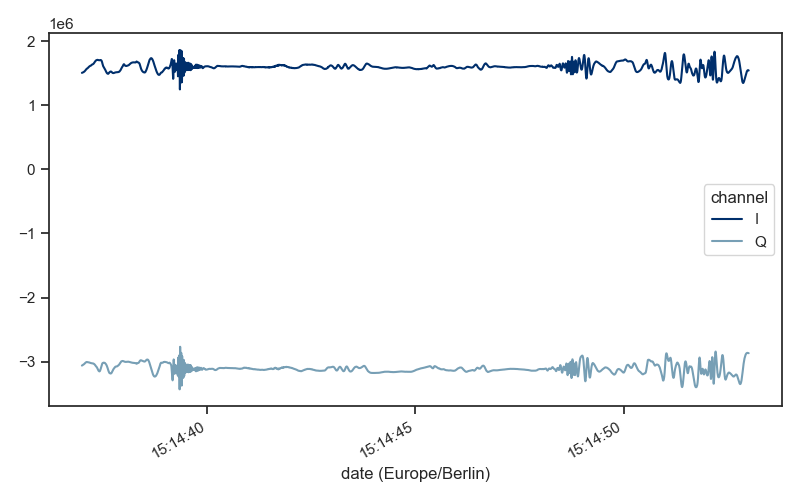

In [34]:
fig, ax = plt.subplots()

data_slice[["I", "Q"]].plot(ax=ax)

fig.tight_layout()

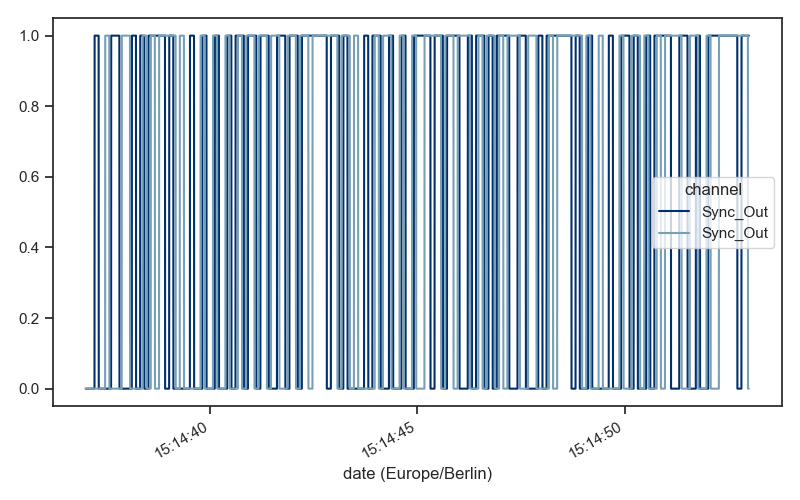

In [60]:
fig, ax = plt.subplots()

test1 = data_slice[["Sync_Out"]]

test2 = data_slice[["Sync_Out"]].copy()
test2 = test2.shift(500, fill_value=0)

test1.plot(ax=ax)
test2.plot(ax=ax)

fig.tight_layout()

In [72]:
n = len(test1)

corr = signal.correlate(test1, test2, mode='same') / np.sqrt(signal.correlate(test1, test1, mode='same')[int(n/2)] * signal.correlate(test2, test2, mode='same')[int(n/2)])

delay_arr = np.linspace(-0.5*n/1953.0, 0.5*n/1953.0, n)
delay_sec = delay_arr[np.argmax(corr)]

delay_sec * 1953.0

-499.5159937241849